In [133]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [134]:
data = pd.read_csv("../data/clean/full_dataset.csv")

In [135]:
data.head()

,ID Number,Preferred Pronouns,Current Grade Level,Program,First Paying Job,Know employee,Applied Before,Comfortable speaking to crowd,Uncomfortable with,Extra activities,...,Application Year,Current Age,Rejected,EECode,EarnHours,EarnRate,EarnAmount,Dist Position Desc,Year,Month
0,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,5.50,13.0,71.50,WILD Steward,2022.0,4.0
1,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,14.47,13.0,188.11,WILD Steward,2022.0,5.0
2,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,7.13,13.0,92.69,WILD Steward,2022.0,5.0
3,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,130.38,13.0,1694.94,WILD Steward,2022.0,6.0
4,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,123.80,13.0,1609.40,WILD Steward,2022.0,7.0


In [136]:
data.columns

Index(['ID Number', 'Preferred Pronouns', 'Current Grade Level', 'Program',
       'First Paying Job', 'Know employee', 'Applied Before',
       'Comfortable speaking to crowd', 'Uncomfortable with',
       'Extra activities', 'Commit Summer', 'Commit Weekday',
       'Hear about source', 'Application Year', 'Current Age', 'Rejected',
       'EECode', 'EarnHours', 'EarnRate', 'EarnAmount', 'Dist Position Desc',
       'Year', 'Month'],
      dtype='object')

In [137]:


data['Commit Summer'] = data['Commit Summer'].fillna('no').map({'yes':2,'no':0, 'unsure':1})
data['Commit Summer'].unique()

array([2, 1, 0], dtype=int64)

In [138]:
data['Commit Weekday'].unique()
data['Commit Weekday'] = data['Commit Weekday'].fillna('no').map({'yes':2,'no':0, 'unsure':1})
data['Commit Weekday'].unique()

array([2, 1, 0], dtype=int64)

In [139]:
data['Hear about source'].unique()
data['Hear about source'] = data['Hear about source'].fillna('no').map({'no':0, 'other':1, 'friend':2, 'school':2,
'social media':1, 'family':2})
data['Hear about source'].unique()

array([1, 2, 0], dtype=int64)

In [140]:
data['EarnHours'] = data['EarnHours'].fillna(0)
data['Current Grade Level'] = data['Current Grade Level'].fillna(0)
data['Comfortable speaking to crowd'] = data['Comfortable speaking to crowd'].fillna(0)
data['Comfortable speaking to crowd'].unique()

array([1., 0.])

In [141]:
X = data[['Current Grade Level', 'First Paying Job', 'Know employee', 'Applied Before',
'Comfortable speaking to crowd','Extra activities','Commit Summer', 'Commit Weekday',
 'Hear about source', 
]]
X

,Current Grade Level,First Paying Job,Know employee,Applied Before,Comfortable speaking to crowd,Extra activities,Commit Summer,Commit Weekday,Hear about source
0,9.0,1,0,0,1.0,0,2,2,1
1,9.0,1,0,0,1.0,0,2,2,1
2,9.0,1,0,0,1.0,0,2,2,1
3,9.0,1,0,0,1.0,0,2,2,1
4,9.0,1,0,0,1.0,0,2,2,1
...,...,...,...,...,...,...,...,...,...
778,11.0,0,1,0,0.0,0,2,2,2
779,10.0,1,0,0,1.0,0,2,2,1
780,10.0,1,0,0,1.0,0,0,2,2
781,10.0,1,1,0,0.0,0,2,2,2


In [142]:

y =  data[['EarnHours']]
y

,EarnHours
0,5.50
1,14.47
2,7.13
3,130.38
4,123.80
...,...
778,0.00
779,0.00
780,0.00
781,0.00


In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [144]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [145]:
model.coef_

array([[-0.5204772 ,  1.62813134,  2.13729355, -1.57143812, 11.34964398,
         4.52874142,  9.4510752 , 11.5338897 , -6.83498031]])

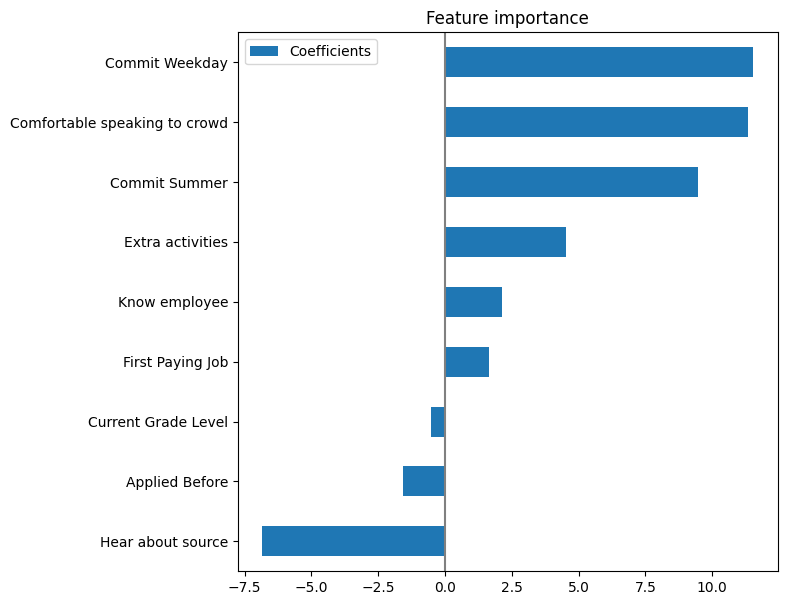

In [146]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   model.coef_.transpose(),
   columns=['Coefficients'], index=X_train.columns
)
coefs = coefs.sort_values(by=['Coefficients'])
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

